In [1]:
# knn, SVM, random forest
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
print("starting")
df = pandas.read_csv("hourly.csv", sep=',', error_bad_lines=False) #ignore bad lines
print(df.columns)
print(df.shape)



starting
Index([u'URL', u'Keywords', u'Keyword Count', u'DateTime', u'Favorite Count', u'Retweet', u'Lang', u'LinkCount', u'Link1', u'Link2', u'Link3', u'Author', u'Text', u'Followers', u'Friends', u'Location', u'Timezone', u'UTC Offset'], dtype='object')
(60000, 18)


In [2]:
df = df[pandas.notnull(df['Text'])]
print(df.columns)
print(df.shape)

Index([u'URL', u'Keywords', u'Keyword Count', u'DateTime', u'Favorite Count', u'Retweet', u'Lang', u'LinkCount', u'Link1', u'Link2', u'Link3', u'Author', u'Text', u'Followers', u'Friends', u'Location', u'Timezone', u'UTC Offset'], dtype='object')
(59983, 18)


In [3]:
# set threshold for binary classifier
#retweets = df.Retweet
threshold = 5000
# train_labels = []
# for num in retweets:
#     if num >= threshold:
#         train_labels.append(1) #viral
#     else:
#         train_labels.append(0) #not viral
df['Viral'] =df['Retweet'].apply(lambda retweet: 1 if retweet >= threshold else 0)
train_labels = df.Viral.values
labels = list(set(train_labels))




In [25]:
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem.snowball import *
stemmer = SnowballStemmer('english')
#stemmer = PorterStemmer('english')

#stopwords?
stop = ['amp', 'cc', 'did', 'don', 'll', 'oh', 've', 'yes', 'let', 'going', 'via', 're', 'tweet' ]
#stop = []
#http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
# preProcess(str):
#     url_pattern = re.compile(r'http(s?)://[\w./]+')
#     pic_pattern = re.compile(r'pic.twitter.com/[\w.]+')
#     str = pic_pattern.sub("", str)
#     str = url_pattern.sub("", str)
#     return str
# http://shahmirj.com/blog/extracting-twitter-usertags-using-regex
class NoUrls_CountVectorizer(CountVectorizer):
    def build_preprocessor(self):
        url_pattern = re.compile(r'http(s?)://[\w./]+')
        pic_pattern = re.compile(r'pic.twitter.com/[\w.]+')
        preprocessor = super(NoUrls_CountVectorizer, self).build_preprocessor()
        return lambda doc: (pic_pattern.sub('', url_pattern.sub('', preprocessor(doc)) ))

class NoUrls_Stemmed_CountVectorizer(CountVectorizer):
    def build_preprocessor(self):
        url_pattern = re.compile(r'(?:\@|https?://)\S+')
        #url_pattern = re.compile(r'http(s?)://)[\w./]+')
        pic_pattern = re.compile(r'pic.twitter.com/[\w.]+')
        at_pattern = re.compile(r' (?<=^|(?<=[^a-zA-Z0-9-_\\.]))@([A-Za-z]+[A-Za-z0-9_]+)')
        preprocessor = super(NoUrls_Stemmed_CountVectorizer, self).build_preprocessor()
        return lambda doc: (pic_pattern.sub('', url_pattern.sub('', preprocessor(doc)) ))
   #right now just doing splits on whitespace and stemming 
    def build_tokenizer(self):
        tokenizer = super(NoUrls_Stemmed_CountVectorizer, self).build_tokenizer()
        return lambda doc: (stemmer.stem(w) for w in tokenizer(doc))

#bigrams? ngram_range=(1,2)
vectorizer = NoUrls_Stemmed_CountVectorizer(ngram_range = (1,1), binary =True,
                                    min_df=1, stop_words=stop, strip_accents='ascii')
   
#example processing
# tweet = "RT @femaIes: When you gotta go visit your broads in Atlanta https://t.co/pCau23tv3q"
# tweet = unicode(tweet, "ascii", "ignore")
# print tweet
# print 'Preprocess:', vectorizer.build_preprocessor()(tweet)
# print
# print 'Analyze:', vectorizer.build_analyzer()(tweet)
# vectorizer.fit_transform([tweet])
# vectorizer.vocabulary_  

print "done"

done


In [27]:
documents = df.Text
X_count = vectorizer.fit_transform(documents)
#print X_count
#print X_count.toarray()
#print vectorizer.get_feature_names()


In [28]:
#http://scikit-learn.org/stable/auto_examples/feature_stacker.html
#trying to append to feature list X
#http://stackoverflow.com/questions/19466868/how-do-i-do-classification-using-tfidfvectorizer-plus-metadata-in-practice
import scipy
linkCount = [df.LinkCount]
linkCount = np.array(linkCount)
X_metadata = scipy.sparse.csr_matrix(linkCount.T) #must transpose to get shape (___, 1)
#print X_metadata
#print X_count
#X_metadata = [df.LinkCount.as_matrix()]
print X_count.shape
print X_metadata.shape
X = scipy.sparse.hstack([X_count, X_metadata])
#print X.toarray()

print X.shape

(59983, 42557)
(59983, 1)
(59983, 42558)


In [29]:
train_labels = np.array(train_labels)
train_features = X

print "train labels: "
print train_labels
print labels
print 
print "train features:"
#print train_features.toarray()

train labels: 
[0 0 0 ..., 0 0 0]
(u'feel', u'22', u'live', u'man', u'ell', u'youngforev', u'sinc', u'first', u'stoke', u'close', u'16', u'saw', u'anyway', u'magic', u'23', u'04', u'trip', u'met', u'jungl', u'contact', u'sound', u'houston', u'tx', u'kept', u'manchest')

train features:


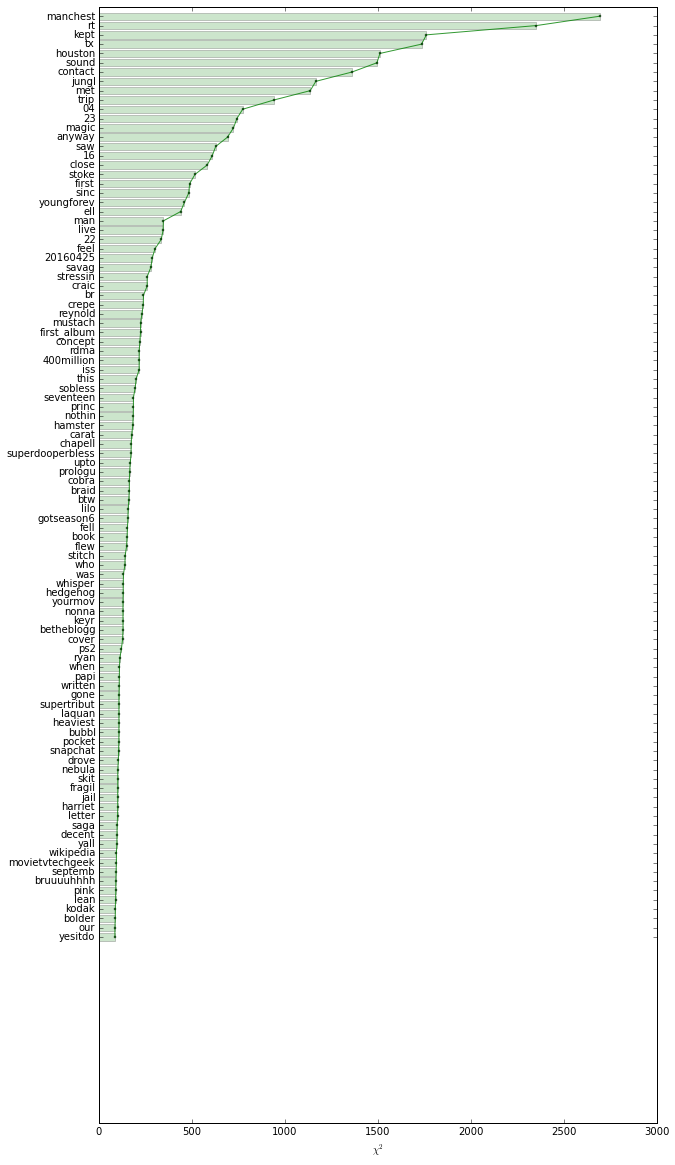

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

chi2score = chi2(train_features, train_labels)[0]

from pylab import barh,plot,yticks,show,grid,xlabel,figure
figure(figsize=(10,20))
wscores = zip(vectorizer.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
k=100
topchi2 = zip(*wchi2[-k:])
x = range(len(topchi2[1]))
labels = topchi2[0]
barh(x,topchi2[1],align='center',alpha=.2,color='g')
plot(topchi2[1],x,'-o',markersize=2,alpha=.8,color='g')
yticks(x,labels)
xlabel('$\chi^2$')
show()

In [2]:
#Make Neural net clasisifier
import tensorflow.contrib.learn as skflow

#Make a pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('vectorizer', NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                    min_df=1, stop_words=stop, strip_accents='ascii')
                    ),
                    ('classifier', skflow.TensorFlowDNNClassifier(hidden_units=[10, 20, 10], n_classes=2)
                    )
                    ])

from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
#adapted from http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
k_fold = KFold(n=len(df), n_folds=10)
scores = []
confusion = np.array([[0, 0], [0, 0]])

i = 1
for train_indices, test_indices in k_fold:
    print "fold "+str(i)
    i += 1
    train_text = df.iloc[train_indices]['Text'].values
    train_y = df.iloc[train_indices]['Viral'].values
    
    test_text = df.iloc[test_indices]['Text'].values
    test_y = df.iloc[test_indices]['Viral'].values
    
    print "\tstart fit"
    pipeline.fit(train_text, train_y)
    print "\tstart predictions"
    predictions = pipeline.predict(test_text)

    #update totals
    confusion += confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=1)
    scores.append(score)
print('Total tweets classified:', len(df))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

ImportError: libcudart.so.7.5: cannot open shared object file: No such file or directory

In [1]:
#Make SVM classifier
from sklearn import svm
#linear or not?
name = "Liblinear"
#loss=?, penalty=?, dual=False?, tol=1e-3
classifier = svm.LinearSVC()
classifier.fit(train_features, train_labels)

/usr/lib/python2.7/dist-packages/sklearn/utils/sparsetools/__init__.py:3: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._min_spanning_tree import minimum_spanning_tree
/usr/lib/python2.7/dist-packages/sklearn/utils/sparsetools/_graph_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._graph_tools import csgraph_to_dense, csgraph_from_dense,\
/usr/lib/python2.7/dist-packages/sklearn/utils/sparsetools/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._traversal import connected_components
/usr/lib/python2.7/dist-packages/sklearn/utils/extmath.py:20: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._logistic_sigmoid import _log_logistic_sigmoid
/usr/lib/python2.7/dist-packages/sklearn/utils/extmath.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .sparsefuncs_fast impor

NameError: name 'train_features' is not defined

In [9]:
#Make a pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer',   NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                    min_df=1, stop_words=stop, strip_accents='ascii')),
    ('classifier',  svm.LinearSVC()) ])

from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
#adapted from http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
k_fold = KFold(n=len(df), n_folds=10)
scores = []
confusion = np.array([[0, 0], [0, 0]])

for train_indices, test_indices in k_fold:
    train_text = df.iloc[train_indices]['Text'].values
    train_y = df.iloc[train_indices]['Viral'].values
    
    test_text = df.iloc[test_indices]['Text'].values
    test_y = df.iloc[test_indices]['Viral'].values
    
    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    #update totals
    confusion += confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=1)
    scores.append(score)
print('Total tweets classified:', len(df))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

('Total tweets classified:', 59983)
('Score:', 0.78294005895103169)
Confusion matrix:
[[56925   420]
 [  669  1969]]


In [ ]:
#Make kNN classifier
#NearestCentroid, KNeighborsClassifier
from sklearn import neighbors
name = "kNN"
# classifier = neighbors.
# KNeighborsClassifier(n_neighbors = 10)
# classifier.fit(train_features, train_labels)

#Make a pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer',   NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                    min_df=1, stop_words=stop, strip_accents='ascii')),
    ('classifier',  neighbors.KNeighborsClassifier(n_neighbors = 4)) ])

from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
#adapted from http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
k_fold = KFold(n=len(df), n_folds=10)
scores = []
confusion = np.array([[0, 0], [0, 0]])

for train_indices, test_indices in k_fold:
    train_text = df.iloc[train_indices]['Text'].values
    train_y = df.iloc[train_indices]['Viral'].values
    
    test_text = df.iloc[test_indices]['Text'].values
    test_y = df.iloc[test_indices]['Viral'].values
    
    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    #update totals
    confusion += confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=1)
    scores.append(score)
print('Total tweets classified:', len(df))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

/usr/lib/python2.7/dist-packages/sklearn/neighbors/__init__.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .ball_tree import BallTree
/usr/lib/python2.7/dist-packages/sklearn/neighbors/__init__.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .kd_tree import KDTree


In [ ]:
#Make Random Forest clasisifier
from sklearn import ensemble
# name = "randomforest"
# classifier = ensemble.RandomForestClassifier(n_estimators=100)
# classifier.fit(train_features, train_labels)

#Make a pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer',   NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                    min_df=1, stop_words=stop, strip_accents='ascii')),
    ('classifier',  ensemble.RandomForestClassifier(n_estimators=100)) ])

from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
#adapted from http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
k_fold = KFold(n=len(df), n_folds=10)
scores = []
confusion = np.array([[0, 0], [0, 0]])

for train_indices, test_indices in k_fold:
    train_text = df.iloc[train_indices]['Text'].values
    train_y = df.iloc[train_indices]['Viral'].values
    
    test_text = df.iloc[test_indices]['Text'].values
    test_y = df.iloc[test_indices]['Viral'].values
    
    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    #update totals
    confusion += confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=1)
    scores.append(score)
print('Total tweets classified:', len(df))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)